# TD3 on Car Racing V2


This notebook contains all the code required to train a Twin Delayed Deep Deterministic Policy Gradient (TD3) algorithm on the CarRacing-v2 Box2D environment. The TD3 algorithm is an extension of the Deep Deterministic Policy Gradient (DDPG) method, designed to address the overestimation bias in Q-learning, which can lead to more stable training and improved performance. To further ensure convergence we conduct hyperparameter tuning using the syne-tune package.


In [1]:
# # General
import platform

assert platform.python_version() == "3.10.14"

## Hyperparameter Tuning


Convergence and stability are common challenges in reinforcement learning. To address this, we employ the Syne Tune package for hyperparameter tuning. Syne Tune is an efficient and flexible tool for automatic hyperparameter optimization, which helps us identify the optimal set of parameters for our TD3 algorithm on the CarRacing-v2 environment. Due to the limited scope of the university project we choose not to include other optimizations such as tweaking the reward function. 

Specifically, we utilize the Asynchronous Successive Halving Algorithm (ASHA), which is designed to allocate resources to promising configurations early and terminate underperforming ones, thereby speeding up the hyperparameter search process. By fine-tuning these hyperparameters, we aim to achieve robust and consistent training results.


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from syne_tune import Tuner
from syne_tune.backend import PythonBackend
from syne_tune.experiments import load_experiment
from syne_tune.config_space import loguniform, uniform
from syne_tune.optimizer.baselines import ASHA
from syne_tune.stopping_criterion import StoppingCriterion

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/adavidho/.config/sagemaker/config.yaml


First we have to define the search space. Here we choose the learning rate, the Polyak update coefficient ($\tau$) and the discount factor ($\gamma$) to be the most important hyperparameters to ensure stable training. The ranges are set based on intuition and defaults provided by the stable_baselines3 package.


In [3]:
# Define the hyperparameter search space
config_space = {
    "learning_rate": loguniform(1e-8, 0.1),
    "tau": loguniform(1e-8, 1),
    "gamma": uniform(0.9, 0.999),
    "steps": 100000,
}

Next we define the tuning function `train_hpo_model()` which will be called inside worker processes spawned by the Syne-Tune scheduler. As `train_hpo_model()` will run inside its on process we need to define all relevant imports inside this function.

The Syne-Tune scheduler will then pass a sampled hyperparameter configuration to the function, which will create an instance of a stable-baselines3 TD3 model and start training it with a reporter callback which communicates with the main tuning process. Note that we use the 'CnnPolicy' as the observed states are images of the environment and that we add noise to actions to facilitate exploration during training.


In [4]:
# Define the tuning function
def train_hpo_model(
    learning_rate: float, tau: float, gamma: float, steps: int
) -> None:
    # Worker imports
    import numpy as np
    from stable_baselines3.common.env_util import make_vec_env
    from stable_baselines3.common.callbacks import BaseCallback
    from stable_baselines3.common.noise import NormalActionNoise
    from stable_baselines3 import TD3

    from syne_tune import Reporter

    # Create the vectorized environment
    env_id = "CarRacing-v2"
    vec_env = make_vec_env(env_id, n_envs=4)

    # Initialize the PPO agent with the given hyperparameters
    n_actions = vec_env.action_space.shape[-1]
    action_noise = NormalActionNoise(
        mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions)
    )
    model = TD3(
        "CnnPolicy",
        vec_env,
        action_noise=action_noise,
        learning_rate=learning_rate,
        tau=tau,
        gamma=gamma,
        batch_size=32,
        verbose=1,
    )

    report = Reporter()

    class WorkerCallback(BaseCallback):
        def _on_step(self) -> bool:
            # Log the mean reward
            mean_reward = sum(self.locals["rewards"]) / len(
                self.locals["rewards"]
            )
            step = self.locals["num_collected_steps"]
            report(step=step, mean_reward=mean_reward)
            return True

    # Train the agent
    worker_callback = WorkerCallback()
    model.learn(total_timesteps=steps, callback=worker_callback)

In [5]:
metric = "mean_reward"
scheduler = ASHA(
    config_space,
    metric=metric,
    max_resource_attr="steps",
    resource_attr="step",
    mode="max",
)
trial_backend = PythonBackend(
    tune_function=train_hpo_model, config_space=config_space
)
stop_criterion = StoppingCriterion(
    max_wallclock_time=61200,
)
tuner = Tuner(
    trial_backend=trial_backend,
    scheduler=scheduler,
    stop_criterion=stop_criterion,
    n_workers=8,
    save_tuner=False,
    wait_trial_completion_when_stopping=True,
)

In the above cell all necessary tuning objects are created and tuning is started in the cell below.


In [6]:
# Start hyperparameter tuning
tuner.run()

--------------------
Resource summary (last result is reported):
 trial_id     status  iter  learning_rate          tau        gamma      steps  step  mean_reward worker-time
        0  Completed   722    6.24041e-06  6.47157e-03  1.24004e-01    3613.77     1      -12.272    7227.53
        1    Stopped  1414    3.56044e-07  4.32651e-03  8.32033e-01    5717.71     1       27.673    11435.43
        2    Stopped   835    6.50236e-06  5.85811e-03  8.92359e-01     4393.6     1        9.095    8787.20
        3    Stopped  2467    7.73109e-06  6.45598e-03  6.62475e-01    2084.03     1       -3.816    4168.07
        4  Completed   862    4.02646e-06  5.81391e-03  3.68519e-01   10883.68     1       34.372    21767.37
        5    Stopped  1325    5.97696e-06  4.04024e-03  4.86856e-01    4499.14     1      -19.657    8998.27
        6  Completed  1821    9.98881e-06  9.98381e-03  8.54684e-01    6858.61     1       45.120    13717.22
        7  Completed  1427    2.78481e-06  8.89039e-03  4.1

In [7]:
# Get results
tuner_path = tuner.tuner_path
tuning_experiment = load_experiment(tuner_path)
best_run = tuning_experiment.best_config()
tuning_experiment.results.to_csv("artifacts/tune_logs/tuning_results.csv")

In [8]:
print("Number of tuning jobs:", len(tuning_experiment.results))
print("Best mean reward:", round(best_run["mean_reward"], 4))
print("Best tuning configuration:")
for i in ["config_learning_rate", "config_tau", "config_gamma"]:
    print(f" - {i}: {best_run[i]:.4e}")

Number of tuning jobs: 293
Best mean reward: 70.810
Best tuning configuration:
 - config_learning_rate: 5.6672e-05
 - config_tau: 7.2524e-06
 - config_gamma: 9.7588e-01


## Training


The approximation optimal hyperparameters fund in the tuning section above will now be used for training a final TD3 model. The training itself is very similar to the behavior of `train_hpo_model()`. However, instead of the reporter callback we now employ a `StopTrainingOnRewardThreshold` callback which determines an early stopping criterion in terms of a reward threshold. This callback is embedded inside the `EvalCallback` which is used to evaluate the model and create best model checkpoints.


In [9]:
import numpy as np
import gymnasium as gym
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.callbacks import StopTrainingOnRewardThreshold
from stable_baselines3 import TD3

Below we create the environment for training which is wrapped `Monitor`. This serves the purpose of tracking the reward of environment interactions and logging it into `artifacts/train_logs/monitor.csv`.


In [10]:
# Create the vectorized environment
env_id = "CarRacing-v2"
log_dir = "./artifacts/train_logs/"
env = gym.make(env_id, domain_randomize=False, render_mode="rgb_array")
env = Monitor(env, log_dir, allow_early_resets=True)

Next we create a new model instance with the optimal hyperparameters found in the tuning section above. The code for training (also the tuning worker above) is based on this [TD3 Pendulum-v1](https://stable-baselines3.readthedocs.io/en/master/modules/td3.html) example from the stable-baselines3 website.


In [11]:
# Initialize optimal hyperparameters
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(
    mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions)
)
learning_rate = best_run["config_learning_rate"]
tau = best_run["config_tau"]
gamma = best_run["config_gamma"]
# Create the TD3 Agent
model = TD3(
    "CnnPolicy",
    env,
    action_noise=action_noise,
    learning_rate=learning_rate,
    tau=tau,
    gamma=gamma,
    batch_size=32,
    verbose=1,
    device="cuda",
)

Using cuda device
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [12]:
# Use DummyVecEnv to create a vectorized environment
eval_env = Monitor(gym.make("CarRacing-v2"), log_dir)
# Define callback for early stopping and include it in the eval callback
callback_on_best = StopTrainingOnRewardThreshold(
    reward_threshold=500, verbose=1
)
best_path = "./artifacts/model/"
eval_callback = EvalCallback(
    eval_env,
    callback_on_new_best=callback_on_best,
    verbose=1,
    best_model_save_path=best_path,
    log_path="./artifacts/logs/",
    eval_freq=1000,
)

The number of time_steps used for training is mostly based on resources limits. Configurations we found in other training examples of TD3 on the CarRacing-v2 environment typically used values two or three orders of magnitude larger which is outside the scope of this university project.

- [Solving CarRacing with DDPG](https://github.com/lzhan144/Solving-CarRacing-with-DDPG/blob/master/car_racing.py)
- [Torch CarRacing TD3](https://blog.csdn.net/Scc_hy/article/details/135179576)
- [Control CartRacing-v2 environment using DQN from scratch](https://hiddenbeginner.github.io/study-notes/contents/tutorials/2023-04-20_CartRacing-v2_DQN.html)

However, we found that the agent still converges with 1M time steps (1000 episodes) and our current hyperparameter configuration within around 10 hours.


In [13]:
# Start training
time_steps = 1000000
model.learn(
    total_timesteps=time_steps, callback=eval_callback, log_interval=10
)
model.save("artifacts/model/td3_car_racing")

/home/adavidho/miniconda3/envs/rl/lib/python3.10/site-packages/stable_baselines3/common/callbacks.py:414: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.vec_transpose.VecTransposeImage object at 0x7effd97c34c0> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f00103b3b80>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


 Eval num_timesteps=1000, episode_reward=-87.25 +/- 1.140372949288352 
 Episode length: 1000.00 +/- 0.00 
 ---------------------------------
 | eval/              |          | 
 |    mean_ep_length  | 1e+03    | 
 |    mean_reward     | -87.25   | 
 | time/              |          | 
 |    total_timesteps | 1000     | 
 | train/             |          | 
 |    actor_loss      | 5.3249   | 
 |    critic_loss     | 1.3312   | 
 |    learning_rate   | 5.67e-05 | 
 |    n_updates       | 899      | 
 --------------------------------- 
 Eval num_timesteps=2000, episode_reward=-85.61 +/- 1.5287179023466968 
 Episode length: 1000.00 +/- 0.00 
 ---------------------------------
 | eval/              |          | 
 |    mean_ep_length  | 1e+03    | 
 |    mean_reward     | -85.61   | 
 | time/              |          | 
 |    total_timesteps | 2000     | 
 | train/             |          | 
 |    actor_loss      | 6.1889   | 
 |    critic_loss     | 1.5472   | 
 |    learning_rate   | 5.67e-05 

# Evaluation


This last section of the notebook contains a visualization of the mean reward for each episode during training and information on the best performing model checkpoint.

Finally, we created a visualization tool that generates an animated sample interaction of the agent with the environment which is saved locally in `artifacts/animation/td3_car_racer.gif`.


In [14]:
import matplotlib.pyplot as plt
from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import load_results
from utils.visualization import render_example

In the plot below we can see that after initial stagnation, during which we assume that the agent learns establishes a fundamental representation of the environment we see a relatively stable increase in the mean episode reward. This reward does not seem to be fully converged and could potentially be improved by training longer.


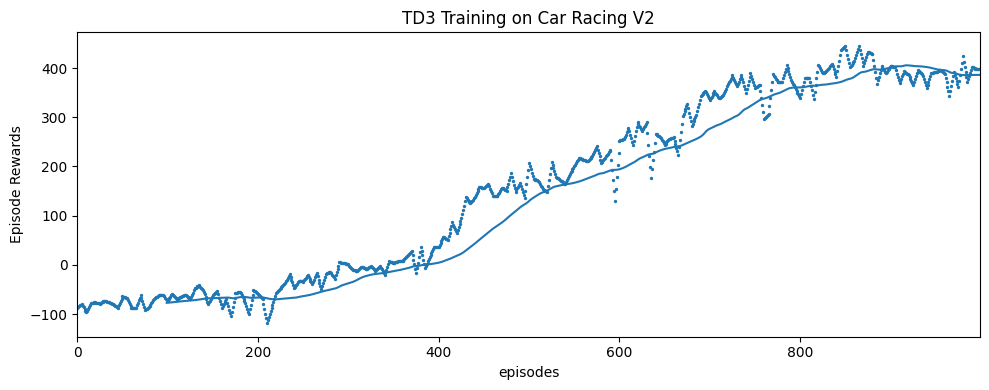

In [15]:
results_plotter.plot_results(
    dirs=[log_dir],
    num_timesteps=time_steps,
    x_axis=results_plotter.X_EPISODES,
    task_name="TD3 Training on Car Racing V2",
    figsize=(10, 4),
)
plt.show()

In [16]:
results_df = load_results(path=log_dir)
best_episode = results_df["r"].idxmax()
print("Best model performance:")
print("- Best mean_reward is ", results_df.loc[best_episode].r)
print("- Reached at episode ", best_episode)
print("- Checkpoint: ", best_path + "best_model.pks")

Best model performance:
- Best mean_reward is  444.361
- Reached at episode  850
- Checkpoint:  ./artifacts/model/best_model.pkl


In [17]:
# Save as gif
render_example(
    model=model,
    env_id=env_id,
    continuous=True,
    render_frames=True,
    output_file="artifacts/animation/td3_car_racer.gif",
)

Saved evaluation GIF to "artifacts/td3_car_racer.gif"